In [9]:
# import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import pydaddy

# Initialize integrator keywords for solve_ivp to replicate the odeint defaults
integrator_keywords = {}
integrator_keywords['rtol'] = 1e-12
integrator_keywords['method'] = 'RK45'
integrator_keywords['atol'] = 1e-12

| Mx range                       : (-0.57, 0.105) |
| Mx mean                        :      -0.05     |
| My range                       :  (-0.338, 1.0) |
| My mean                        :       0.0      |
| |M| range                      :   (0.0, 1.0)   |
| |M| mean                       :      0.112     |
| Autocorr time (Mx, My, |M^2|)  : (106, 50, 154) |
| (Dt, dt)                       :     (1, 1)     |



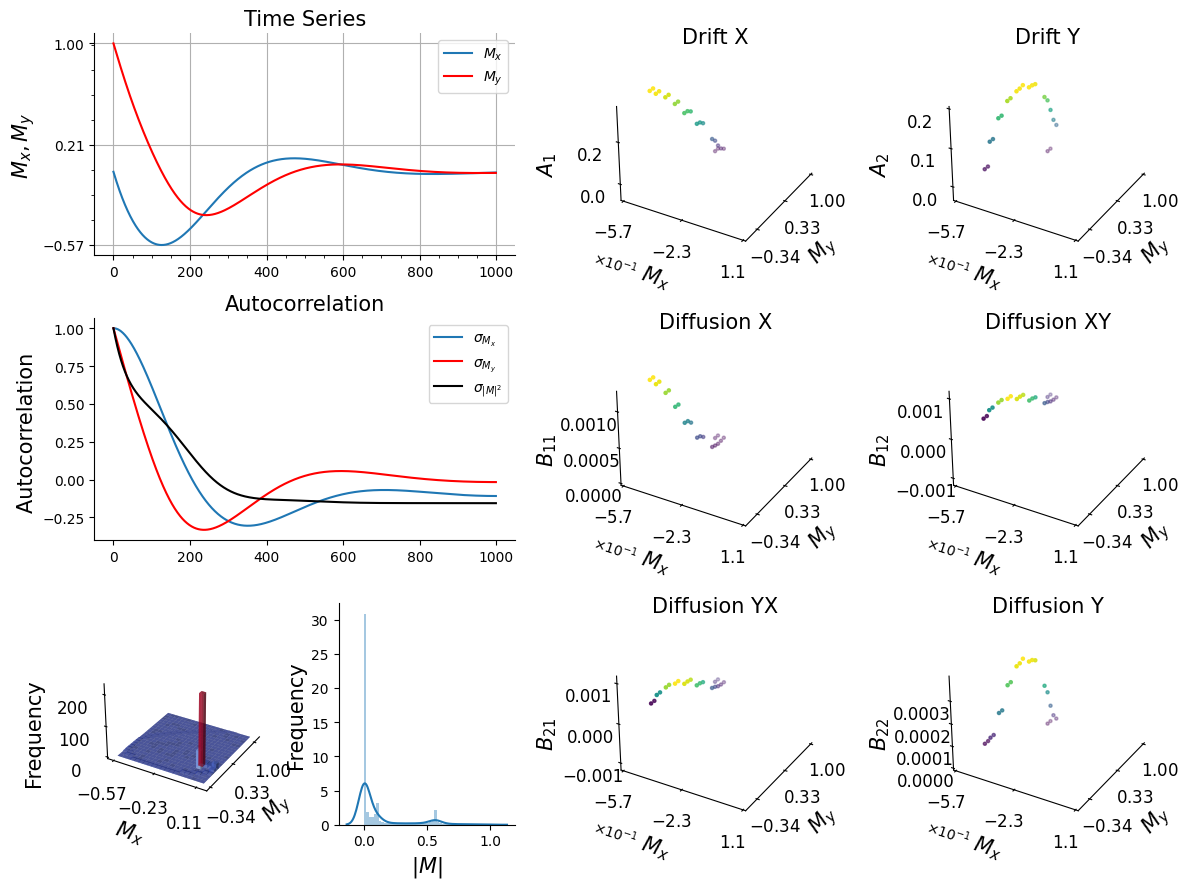

In [7]:
# Generate measurement data
dt = .01

t_train = np.arange(0, 20, dt)
x0_train = [0, 1]
t_train_span = (t_train[0], t_train[-1])
dim = 2
multiple = True

def van_der_pol(t, x, p=[1]):
    return [-x[1],  x[0] - p[0] * (1 - x[0] ** 2) * x[1]]

# def vf(t, x):
#     x1 = x[0]
#     x2 = x[1]
#     y = [-x1 - 2*x2 +x1**3, -x2 + 0.5* x1**2 * x2 + x1**3]
#     return y
def vf(t, x):
    x1 = x[0]
    x2 = x[1]
    x3 = x[2] 
    y1 = -x1 -x2 -x3
    y2 = np.sin(x1) -2*x2*(1+x1) +x3
    y3 = x1 *(1+x1) +x2 -2*np.sin(x3)
    y = [y1, y2, y3]
    return y


# (1000,2)
x_train = solve_ivp(fun = van_der_pol, 
            t_span = t_train_span, y0 = x0_train, t_eval=t_train,
             **integrator_keywords).y.T

# x_train = x_train + np.random.normal(0 ,0.1, (x_train.shape[0], x_train.shape[1]))
ddsde = pydaddy.Characterize([x_train[:,0], x_train[:,1]], t=t_train, bins =20)

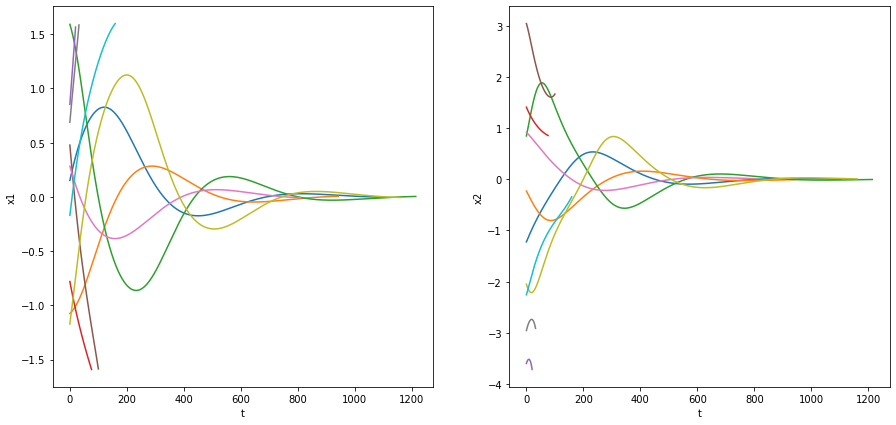

In [23]:
# Generate measurement data
dt = .01

bounds = [1.6,4]
t_train = np.arange(0, 20, dt)
# x0_train = [0, 0.5]
t_train_span = (t_train[0], t_train[-1])
dim = 2
multiple = True
n_traj = 10

def van_der_pol(t, x, p=[1]):
    return [-x[1],  x[0] - p[0] * (1 - x[0] ** 2) * x[1]]
def vf(x):
    y = [-x[:,1], x[:,0] - (1-x[:,0]**2)*x[:,1]]
    return np.array(y).T

def re(ls, thrsh, num):
    # slice array if it converged
    ct = 0
    for i in range(len(ls)):
        if np.abs(np.sum(ls[i])) < thrsh:
            ct +=1
        elif np.abs(np.sum(ls[i])) >= thrsh:
            ct = 0
        if ct >= num:
            return np.array(ls[:i-ct])
        # if it diverges, slice it
        if ((np.abs(ls[i][1]) > bounds[1]) or (np.abs(ls[i][0]) > bounds[0])):
            return np.array(ls[:i])
    return np.array(ls)

def create_multiple_timeseries(func, n_trajectories, dim):
    x_train_multi = []
    y_train_multi = []
#     x0s = np.random.rand(n_trajectories, dim)
    x0s = np.random.uniform(low=[ -x for x in bounds], high=bounds, size=(n_trajectories,dim))

#     print(x0s)
    plt.figure(figsize=(15,7))
    for i in range(n_trajectories):
        x_train_temp = solve_ivp(fun = func, t_span=t_train_span, 
                                    y0 = x0s[i], t_eval=t_train, **integrator_keywords).y.T
        # x1_temp = x_train_temp[:,0]
        # x2_temp = x_train_temp[:,1]
        # # print('before: {}'.format(x_train_temp.shape))
        # # print( int(t_train.shape[0] / 10))
        # x1_temp = re(x1_temp, 1e-5, 5)
        # x2_temp = re(x2_temp, 1e-5, 5)
        # print('after: {}'.format(x_train_temp.shape))
        x_train_temp = re(x_train_temp, 1e-3, 5)
        plt.subplot(121)
        plt.plot(x_train_temp[:,0])
        plt.xlabel('t')
        plt.ylabel('x1')
        plt.subplot(122)
        plt.plot(x_train_temp[:,1])
        plt.xlabel('t')
        plt.ylabel('x2')
        x_train_multi.append(x_train_temp)
    # now get finite difference approximations for each time series
    for x_train in x_train_multi:
        forward_diff = np.expand_dims(np.diff(x_train[:,0]) / dt, axis=1)
        forward_diff2 = np.expand_dims(np.diff(x_train[:,1]) / dt, axis=1)
        y_t = np.concatenate([forward_diff, forward_diff2], axis=1)
        y_train_multi.append(y_t)
    # slice first element to match y
    x_train_multi = [i[1:,:] for i in x_train_multi]
    return np.concatenate(x_train_multi), np.concatenate(y_train_multi)
    
x_train_multi, y_train_multi = create_multiple_timeseries(van_der_pol, n_traj, dim)
# t_diff = t_train[:-1:]

| Mx range                       : (-1.592, 1.598)|
| Mx mean                        :      0.029     |
| My range                       : (-3.717, 3.022)|
| My mean                        :     -0.013     |
| |M| range                      : (0.005, 4.033) |
| |M| mean                       :      0.471     |
| Autocorr time (Mx, My, |M^2|)  :  (116, 85, 70) |
| (Dt, dt)                       :     (1, 1)     |



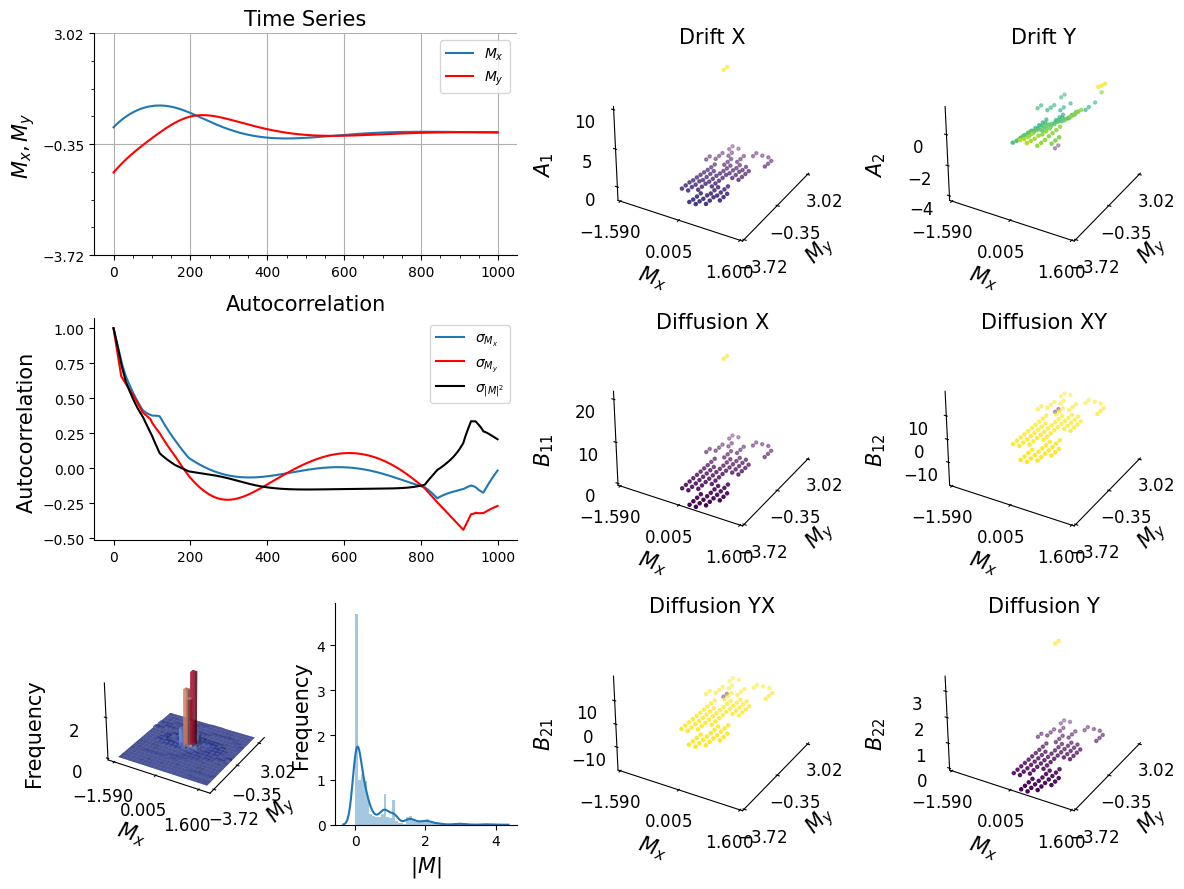

In [24]:
ddsde = pydaddy.Characterize([x_train_multi[:,0], x_train_multi[:,1]], t=np.linspace(0, 100, x_train_multi.shape[0]), bins =20)

In [17]:
x_train_multi[:,0].shape

(17056,)

In [25]:
A1 = ddsde.fit('A1', order=3, tune=True)
A2 = ddsde.fit('A2', order=3, tune=True)
B11 = ddsde.fit('B11', order=3, tune=True)
B22 = ddsde.fit('B22', order=3, tune=True)
B21 = ddsde.fit('B21', order=3, tune=True)
for i in [A1, A2, B11, B22, B21]:
    print(i)
    print('--'*30)

(1.054 ± 0.209)x + (-1.095 ± 0.173)x^3 + (-1.117 ± 0.141)y + (1.193 ± 0.144)x^2y
------------------------------------------------------------
(-1.499 ± 0.394)x + (-0.264 ± 0.259)x^2 + (1.459 ± 0.326)x^3 + (0.321 ± 0.266)y + (-0.953 ± 0.270)x^2y + (0.626 ± 0.133)xy^2
------------------------------------------------------------
(1.969 ± 0.311)x^2
------------------------------------------------------------
(-4.562 ± 2.178)x + (6.330 ± 1.433)x^2 + (-4.371 ± 1.802)x^3 + (4.745 ± 1.472)y + (-8.062 ± 1.493)x^2y + (5.010 ± 0.736)xy^2
------------------------------------------------------------
(-2.635 ± 0.397)x^2 + (2.619 ± 0.499)x^3 + (-0.873 ± 0.407)y + (1.535 ± 0.413)x^2y + (-1.064 ± 0.204)xy^2
------------------------------------------------------------


| Mx range                       : (-0.759, 0.318)|
| Mx mean                        :     -0.099     |
| My range                       : (-0.621, 1.064)|
| My mean                        :     -0.003     |
| |M| range                      : (0.004, 1.067) |
| |M| mean                       :      0.278     |
| Autocorr time (Mx, My, |M^2|)  :  (88, 50, 83)  |
| (Dt, dt)                       :     (1, 1)     |

Drift (A1): (3.782 ± 0.567) + (-42.082 ± 3.574)x + (-176.489 ± 16.259)x^2 + (-177.826 ± 27.099)x^3 + (-5.179 ± 3.529)y + (65.366 ± 18.470)xy + (92.289 ± 36.542)x^2y + (-78.546 ± 8.896)y^2 + (-150.958 ± 24.040)xy^2 + (71.983 ± 10.743)y^3
Drift (A2): (-47.600 ± 40.248)x^2y
Diffusion (B11): (39.897 ± 3.961)x^2 + (56.750 ± 6.602)x^3 + (-14.908 ± 4.500)xy + (-16.491 ± 8.903)x^2y + (15.800 ± 2.167)y^2 + (39.925 ± 5.857)xy^2 + (-12.424 ± 2.618)y^3
Diffusion (B22): (1.545 ± 0.120) + (1.913 ± 0.750)y + (2.799 ± 3.924)xy + (3.561 ± 7.764)x^2y + (10.986 ± 1.890)y^2 + (18.464 ± 5.108)xy^2

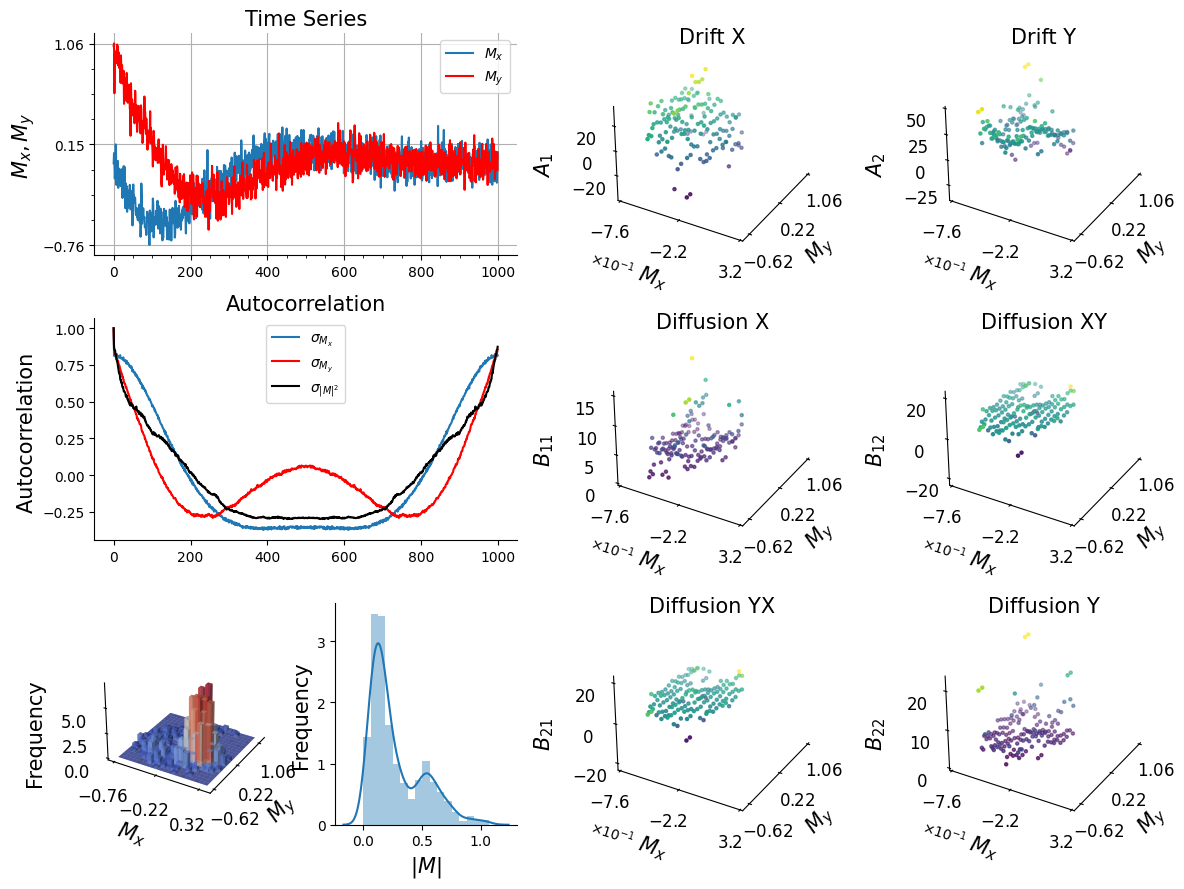

In [4]:
ddsde.summary()

Noise statistics:
Mean: (0.9049, 0.5771)
Correlation matrix:
    +1.0000    +0.1679
    +0.1679    +1.0000

Noise autocorrelation time:
    eta_x: 0.037 timesteps (0.000s)    eta_y: 0.034 timesteps (0.000s)


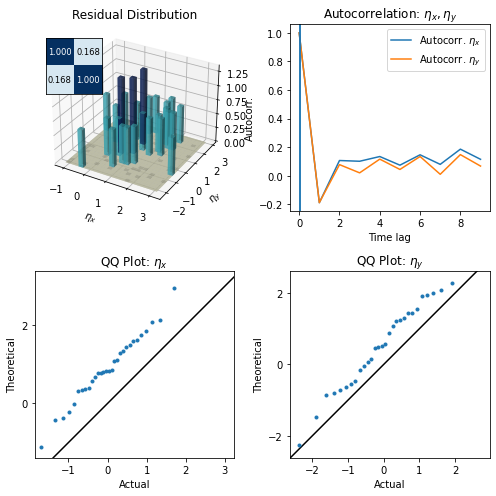

In [5]:
ddsde.noise_diagnostics()

In [6]:
ddsde.fit_diagnostics()


Drift:
 A1 = (3.782 ± 0.567) + (-42.082 ± 3.574)x + (-176.489 ± 16.259)x^2 + (-177.826 ± 27.099)x^3 + (-5.179 ± 3.529)y + (65.366 ± 18.470)xy + (92.289 ± 36.542)x^2y + (-78.546 ± 8.896)y^2 + (-150.958 ± 24.040)xy^2 + (71.983 ± 10.743)y^3
    Adjusted R-squared : -5.3216
    Adjusted R-squared (without outliers) : -6.6740

Drift:
 A2 = (-47.600 ± 40.248)x^2y
    Adjusted R-squared : -0.2146
    Adjusted R-squared (without outliers) : -0.1395

Diffusion:
 B11 = (39.897 ± 3.961)x^2 + (56.750 ± 6.602)x^3 + (-14.908 ± 4.500)xy + (-16.491 ± 8.903)x^2y + (15.800 ± 2.167)y^2 + (39.925 ± 5.857)xy^2 + (-12.424 ± 2.618)y^3
    Adjusted R-squared : -6.8347
    Adjusted R-squared (without outliers) : -7.9885

Diffusion:
 B22 = (1.545 ± 0.120) + (1.913 ± 0.750)y + (2.799 ± 3.924)xy + (3.561 ± 7.764)x^2y + (10.986 ± 1.890)y^2 + (18.464 ± 5.108)xy^2 + (-10.871 ± 2.283)y^3
    Adjusted R-squared : -1.2352
    Adjusted R-squared (without outliers) : -1.4708

Cross-diffusion:
 B12 = B21 = 0
    Adjusted

In [7]:
x_train + np.random.normal(loc = 0.0, scale = 0.1)

array([[-0.06934609,  0.9932412 ],
       [ 0.02204309,  1.01393586],
       [-0.0670013 ,  0.56313666],
       ...,
       [-0.24615487, -0.01977514],
       [-0.06896383, -0.13673293],
       [ 0.03057743,  0.01808863]])

(array([-10,  -9,  -8,  -7,  -6,  -5,  -4,  -3,  -2,  -1,   0,   1,   2,
          3,   4,   5,   6,   7,   8,   9,  10]),
 array([0.99514946, 0.99605823, 0.99687531, 0.99759976, 0.99823066,
        0.9987671 , 0.99920815, 0.99955288, 0.99980039, 0.99994973,
        1.        , 0.99994973, 0.99980039, 0.99955288, 0.99920815,
        0.9987671 , 0.99823066, 0.99759976, 0.99687531, 0.99605823,
        0.99514946]),
 <matplotlib.lines.Line2D at 0x7f94351a9d90>)

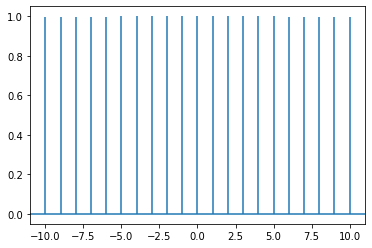

In [16]:
plt.acorr(x_train[:,0])

In [4]:
ep = pydaddy.visualize.Visualize()
ep._plot_summary(x_train)

TypeError: __init__() missing 4 required positional arguments: 'op_x', 'op_y', 'op', and 'autocorrelation_time'